In [ ]:
import pandas as pd
!pip install odfpy
file_name = '/content/sample_data/prc-pfa-mar2013-onwards-tables-191023.ods'

#code for converting spreadsheet to csv file
xlsx = pd.ExcelFile(file_name)
for sheet_name in xlsx.sheet_names:
    df = xlsx.parse(sheet_name)
    csv_file = f"{sheet_name}.csv"
    df.to_csv(csv_file, index=False)

#setting apache spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

#setting the environment
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

#shows files
!ls

#creating spark session
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
spark = SparkSession.builder \
    .appName("merge using sql ") \
    .config("spark.jars.packages", "com.crealytics:spark-excel_2.12:0.13.1") \
    .getOrCreate()

#spark = SparkSession.builder.appName("merge using sql").getOrCreate()

files = ["/content/2012-13.csv", "/content/2017-18.csv", "/content/2022-23.csv"]

#to read csv files
def read_csv_and_create_view(files, view_name):
    df = spark.read.csv(csv_file, header=True, inferSchema=True)
    df.createOrReplaceTempView(view_name)


#creating temproray views
for i, csv_file in enumerate(files):
    view_name = f"temp_view_{i}"
    read_csv_and_create_view(csv_file, view_name)

#sql query to merge 3 csv files
query = " UNION ALL ".join([f"SELECT * FROM temp_view_{i}" for i in range(len(files))])

merged_df = spark.sql(query)

merged_df.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.0/717.0 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for odfpy: filename=odfpy-1.4.1-py2.py3-none-any.whl size=160673 sha256=2859ef8c620c40361fdae0e14b634120a3f2bf6881fcc1e1030a23cc0205148b
  Stored in directory: /root/.cache/pip/wheels/c8/2e/95/90d94fe33903786937f3b8c33dd88807f792359c6424b40469
Successfully built odfpy
2012-13.csv  2015-16.csv  2018-19.csv  2021-22.csv  Cover_sheet.csv  spark-3.1.1-bin-hadoop3.2
2013-14.csv  2016-17.csv  2019-20.csv  2022-23.csv  Notes_.csv	     spark-3.1.1-bin-hadoop3.2.tgz
2014-15.csv  2017-18.csv  2020-21.csv  2023-24.csv  sample_data
+--------------+-----------------+-----------------+--------------------+--------------------+--------------------+------------+------------------+
|Financial Year|Financial Quarter|       Force Name| Offence Description|       Offence Group|    Offence Subgroup|Offence Code|Number of Offences|
+--------------+-----------------+-----

In [ ]:
#checking for null values ,counts the number of missing values in each column
from pyspark.sql import functions as F
missing_values = merged_df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in merged_df.columns])
missing_values.show()

+--------------+-----------------+----------+-------------------+-------------+----------------+------------+------------------+
|Financial Year|Financial Quarter|Force Name|Offence Description|Offence Group|Offence Subgroup|Offence Code|Number of Offences|
+--------------+-----------------+----------+-------------------+-------------+----------------+------------+------------------+
|             0|                0|         0|                  0|            0|               0|           0|                 0|
+--------------+-----------------+----------+-------------------+-------------+----------------+------------+------------------+



In [ ]:

q1 = merged_df.orderBy('Number of Offences')
q1.show(250)


+--------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------+------------------+
|Financial Year|Financial Quarter|          Force Name| Offence Description|       Offence Group|    Offence Subgroup|  Offence Code|Number of Offences|
+--------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------+------------------+
|       2012/13|                3|British Transport...|    Violent disorder|Public order offe...|Public order offe...|           62A|              -268|
|       2012/13|                4|         North Wales|Fraud by false re...|      Fraud offences|Fraud offences to...|           53D|              -118|
|       2012/13|                4|        Bedfordshire|Fraud by false re...|      Fraud offences|Fraud offences to...|           53C|               -94|
|       2012/13|                4|  Greater Manchester|Fraud by false re...|      

In [ ]:
# Converting PySpark DataFrame to a pandas DataFrame
from google.colab import data_table
df_table = merged_df.toPandas()
data_table.DataTable(df_table, include_index=False)

In [ ]:
print(df_table.isnull().sum())

In [ ]:
# to download the merged file
from google.colab import files
df_table.to_csv('crimedata.csv', index=False)
files.download('crimedata.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
df = pd.read_csv('/content/sample_data/crimedata.csv')

# For numeric columns, calculate Z-scores and define outliers
numeric_cols = df.select_dtypes(include=[np.number])
# Print the outliers for each numeric column
for col in numeric_cols:
    z_scores = stats.zscore(df[col])
    outliers = df[col][(np.abs(z_scores) > 3)]
    print(f"Outliers in {col}:")
    print(outliers)

# For numeric columns, define any negative value as an outlier
numeric_cols = df.select_dtypes(include=[np.number])
# Print the outliers for each numeric column
for col in numeric_cols:
    outliers = df[col][df[col] < 0]
    print(f"Negative outliers in {col}:")
    print(outliers)

# For categorical columns, print the count of each category
categorical_cols = df.select_dtypes(include=['object'])
for col in categorical_cols:
    print(df[col].value_counts())



Outliers in Financial Quarter:
Series([], Name: Financial Quarter, dtype: int64)
Outliers in Number of Offences:
0         20323
771       55423
2004      30858
3865      13943
3867       9456
          ...  
73951     96612
73952    128818
73953     78312
73954     88141
73955    113476
Name: Number of Offences, Length: 287, dtype: int64
Negative outliers in Financial Quarter:
Series([], Name: Financial Quarter, dtype: int64)
Negative outliers in Number of Offences:
407      -1
715      -3
6835     -1
6865     -1
6878    -15
         ..
27019    -5
27020    -6
27052    -1
27077    -1
27082    -2
Name: Number of Offences, Length: 212, dtype: int64
2012/13    27116
2022/23    23772
2017/18    23068
Name: Financial Year, dtype: int64
Leicestershire               1680
West Midlands                1680
Avon and Somerset            1680
Lincolnshire                 1680
London, City of              1680
Merseyside                   1680
Metropolitan Police          1680
Norfolk             

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np

df = pd.read_csv('/content/sample_data/crimedata.csv')

# For numeric columns, replace negative and high values with the mean of the other values
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
    # Calculate the mean of the other values in the column
    mean_cal = df[(df[col] >= 0) & (df[col] <= df[col].quantile(0.95))][col].mean()
    mean_int=int(mean_cal)

    # Replace negative and high values with the mean
    df[col] = np.where((df[col] < 0) | (df[col] > df[col].quantile(0.95)), mean_int, df[col])

# Print the DataFrame
print(df)



      Financial Year  Financial Quarter         Force Name  \
0            2012/13                  1       Action Fraud   
1            2012/13                  1  Avon and Somerset   
2            2012/13                  1  Avon and Somerset   
3            2012/13                  1  Avon and Somerset   
4            2012/13                  1  Avon and Somerset   
...              ...                ...                ...   
73951        2022/23                  3              CIFAS   
73952        2022/23                  3         UK Finance   
73953        2022/23                  4       Action Fraud   
73954        2022/23                  4              CIFAS   
73955        2022/23                  4         UK Finance   

                                     Offence Description  \
0                Fraud offences recorded by Action Fraud   
1       Abandoning child under two years (outcomes only)   
2                         Absconding from lawful custody   
3      Abuse of

In [ ]:
a = df.sort_values('Number of Offences')[['Number of Offences']]
print(a)

       Number of Offences
28051                   0
22867                   0
49293                   0
22860                   0
22859                   0
...                   ...
27683                 959
34509                 959
71422                 959
50648                 959
46051                 959

[73956 rows x 1 columns]


In [ ]:
original_data = pd.read_csv('/content/sample_data/crimedata.csv')
# Assuming original_data is your original DataFrame before imputation
print("Summary Statistics Before Imputation:")
print(original_data.describe())
data = pd.read_csv('/content/sample_data/cleancrimedata.csv')
print("\nSummary Statistics After Imputation:")
print(data.describe())

Summary Statistics Before Imputation:
       Financial Quarter  Number of Offences
count       73956.000000        73956.000000
mean            2.500000          220.788969
std             1.118042         1721.397715
min             1.000000         -268.000000
25%             1.750000            0.000000
50%             2.500000            7.000000
75%             3.250000           72.000000
max             4.000000       128818.000000

Summary Statistics After Imputation:
         Unnamed: 0  Financial Quarter  Number of Offences
count  73956.000000       73956.000000        73956.000000
mean   36977.500000           2.500000           70.100911
std    21349.402591           1.118042          152.981616
min        0.000000           1.000000            0.000000
25%    18488.750000           1.750000            0.000000
50%    36977.500000           2.500000            7.000000
75%    55466.250000           3.250000           70.000000
max    73955.000000           4.000000         

In [ ]:

# Save the clean DataFrame to a new CSV file
df.to_csv('cleancrimedata.csv', header=True)
from google.colab import files
files.download('cleancrimedata.csv')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv('/content/sample_data/cleancrimedata.csv')

# For numeric columns, create box plots
numeric_cols = df.select_dtypes(include=[np.number])
for col in numeric_cols:
    plt.figure(figsize=(2, 2))
    sns.boxplot(x=df[col])
    plt.title(f'Box plot of {col}')
    plt.show()

# For categorical columns, create count plots
categorical_cols = df.select_dtypes(include=['object'])
for col in categorical_cols:
    plt.figure(figsize=(2, 2))
    sns.countplot(x=df[col])
    plt.title(f'Count plot of {col}')
    plt.show()


In [ ]:
df = pd.read_csv('/content/sample_data/cleancrimedata.csv')

force_with_max_offences = df.groupby('Force Name')['Number of Offences'].sum().idxmax()

print(f"The Force Name with the highest occurrence of number of offences is: {force_with_max_offences}")



The Force Name with the highest occurrence of number of offences is: Metropolitan Police


In [ ]:
!pip install pyspark

# Import necessary libraries
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("sql1").getOrCreate()

# Load your DataFrame into Spark
df = spark.read.csv('/content/sample_data/cleancrimedata.csv', header=True, inferSchema=True)

# Register the DataFrame as a SQL temporary view
df.createOrReplaceTempView("crimedata")

# SQL query to find the Force Name with the highest occurrence of number of offences
query = """
SELECT `Force Name`,  SUM(`Number of Offences`) as Total_Offences
FROM crimedata
GROUP BY `Force Name`
ORDER BY Total_Offences DESC
"""
result=spark.sql(query)

# Show the result
result.show()



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=9269b12e257e3d6e2d84c9e0937f359f86a29fb5d17f5ee4350f29d0924cc281
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark
+-------------------+--------------+
|         Force Name|Total_Offences|
+-------------------+--------------+
|Metropolitan Police|        196875|
|     West Yorkshire|        190276|
| Greater Manchester|        181185|
|      West Midlands|        163377|
|      Thames Valley|        150687|
|          Hampshire|        149718|
|               Kent|        142999|
|             Sussex|        142928|
|              Essex|        142849|
|         Merseyside|        138540|
|  Avon and Somerset|        136377|
|    South Yorkshire|        131692|
|        South Wales|       

In [ ]:

# Group by 'Force_Area' and 'Offence_Group', calculate the count of 'Number_of_Offences'
result = df.groupBy('Force Name', 'Offence Group').agg(F.sum('Number of Offences').alias('total_of_Offences'))

# Show the result
result.show(50)


In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("sql2").getOrCreate()

# Load your DataFrame into Spark
df = spark.read.csv('/content/sample_data/cleancrimedata.csv', header=True ,inferSchema=True)

# Register the DataFrame as a SQL temporary view
df.createOrReplaceTempView("crimedata")

# SQL query to find the total number of offences for each offence group in each force area
query = spark.sql("""
SELECT `Force Name` as forcename, `Offence Group` as offencegroup, SUM(`Number of Offences`) as total_offences
FROM crimedata
GROUP BY forcename, offencegroup
ORDER BY total_offences DESC
""")
# Show the result
query.show(50)


+-------------------+--------------------+--------------+
|          forcename|        offencegroup|total_offences|
+-------------------+--------------------+--------------+
|     West Yorkshire|      Theft offences|         59553|
|          Hampshire|      Theft offences|         54249|
|      Thames Valley|      Theft offences|         53534|
|         Merseyside|      Theft offences|         52430|
|               Kent|      Theft offences|         51673|
|             Sussex|      Theft offences|         50916|
|    South Yorkshire|      Theft offences|         49892|
|       Bedfordshire|      Theft offences|         49865|
|         Lancashire|      Theft offences|         49503|
|      Staffordshire|      Theft offences|         49423|
|  Avon and Somerset|      Theft offences|         49362|
|Metropolitan Police|Violence against ...|         47347|
|              Essex|      Theft offences|         47285|
|             Surrey|      Theft offences|         47221|
|        North

In [ ]:
from pyspark.sql import functions as F

# Group by 'Force_Area' and 'Financial_Quarter', calculate the sum of 'Number_of_Offences'
result = df.groupBy('Force Name','Financial Quarter').agg(F.sum('Number of Offences').alias('Total_Offences'))

# Find the row with the maximum 'Total_Offences'
max_row = result.orderBy(F.desc('Total_Offences')).first()

print(f"The Force Area with the highest number of offences is: {max_row['Force Name']}")
print(f"This occurred in the financial quarter: {max_row['Financial Quarter']}")
print(f"The total number of offences was: {max_row['Total_Offences']}")



In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("sql3").getOrCreate()

# Load your DataFrame into Spark
df = spark.read.csv('/content/sample_data/cleancrimedata.csv', header=True,inferSchema=True)

# Register the DataFrame as a SQL temporary view
df.createOrReplaceTempView("crime_data")

# SQL query to find the Force Area and the financial quarter with the highest occurrence of number of offences
query = """
SELECT `Force Name`, `Financial Quarter`, SUM(`Number of Offences`)as Total_Offences
FROM crime_data
GROUP BY `Force Name`, `Financial Quarter`
ORDER BY Total_Offences DESC
"""

# Execute the query and store the result in a DataFrame
result = spark.sql(query)

# Show the result
result.show()





+-------------------+-----------------+--------------+
|         Force Name|Financial Quarter|Total_Offences|
+-------------------+-----------------+--------------+
|Metropolitan Police|                3|         50491|
|Metropolitan Police|                2|         49759|
|     West Yorkshire|                3|         49211|
|Metropolitan Police|                4|         48573|
|Metropolitan Police|                1|         48052|
|     West Yorkshire|                2|         47564|
|     West Yorkshire|                4|         47440|
| Greater Manchester|                4|         46935|
|     West Yorkshire|                1|         46061|
| Greater Manchester|                3|         45240|
| Greater Manchester|                1|         45214|
| Greater Manchester|                2|         43796|
|      West Midlands|                2|         42725|
|      West Midlands|                1|         41759|
|      West Midlands|                3|         40300|
|      Tha

In [ ]:
from pyspark.sql import functions as F
df = spark.read.csv('/content/sample_data/cleancrimedata.csv', header=True,inferSchema=True)

# Assuming 'merged_df' is your DataFrame and 'Force Name' and 'Number of Offences' are your columns
code_with_max_offences = df.groupBy('Offence Code').agg(F.sum('Number of Offences').alias('Total Offences')).orderBy(F.desc('Total Offences')).first()

print(f"The Force Name with the highest occurrence of number of offences is: {code_with_max_offences['Offence Code']}")
print(f"The total number of offences for this Force Name is: {code_with_max_offences['Total Offences']}")


The Force Name with the highest occurrence of number of offences is: 58A
The total number of offences for this Force Name is: 207512


In [ ]:
sub = '''
SELECT `Offence Subgroup`, `Financial Year`, COUNT(`Number of Offences`) as  total_count
FROM crime_data
GROUP BY `Offence Subgroup`, `Financial Year`
ORDER BY  total_count DESC
'''
result = spark.sql(sub)
result.show()

+--------------------+--------------+-----------+
|    Offence Subgroup|Financial Year|total_count|
+--------------------+--------------+-----------+
|Miscellaneous cri...|       2012/13|       5984|
|Miscellaneous cri...|       2017/18|       4224|
|Miscellaneous cri...|       2022/23|       4224|
|Violence with injury|       2012/13|       3872|
|Other sexual offe...|       2017/18|       2816|
|Other sexual offe...|       2012/13|       2816|
|Other sexual offe...|       2022/23|       2816|
|Violence without ...|       2012/13|       2288|
|Violence without ...|       2017/18|       1760|
|   Domestic burglary|       2022/23|       1760|
|Violence without ...|       2022/23|       1760|
|   Domestic burglary|       2017/18|       1760|
|Violence with injury|       2022/23|       1584|
|     Criminal damage|       2012/13|       1584|
|Fraud offences to...|       2012/13|       1408|
|Other theft offences|       2022/23|       1408|
|Other theft offences|       2012/13|       1408|


In [ ]:

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("hive").enableHiveSupport().getOrCreate()

data_file = spark.read.csv("/content/sample_data/cleancrimedata.csv", header=True, inferSchema=True)

data_file.createOrReplaceTempView("crimedata")

result = spark.sql("SELECT `Offence Code`, COUNT(`Number of Offences`) as count,  SUM(`Number of Offences`) as total  FROM crimedata GROUP BY `Offence Code` ORDER BY  total DESC")

result.show()






+------------+-----+------+
|Offence Code|count| total|
+------------+-----+------+
|         58A|  528|207512|
|         58D|  528|206259|
|         58C|  528|182975|
|         92E|  528|171426|
|          44|  528|170745|
|          45|  528|167897|
|          48|  528|154650|
|         58B|  528|151213|
|          9A|  528|141360|
|          49|  528|133219|
|          8L|  528|131394|
|         49A|  528|130673|
|         28E|  352|129480|
|          66|  528|125395|
|          40|  528|124060|
|          46|  528|122124|
|         30C|  352|118693|
|          39|  528|109373|
|        105A|  528|105773|
|          8R|  352|100621|
+------------+-----+------+
only showing top 20 rows



In [ ]:
# Create a SparkSession
spark = SparkSession.builder.appName("hive2").enableHiveSupport().getOrCreate()

# Load the data
data_file = spark.read.csv("/content/sample_data/cleancrimedata.csv", header=True, inferSchema=True)

# Register the DataFrame as a SQL temporary view
data_file.createOrReplaceTempView("crimedata")

# Execute the SQL query
result = spark.sql("""
    SELECT `Financial Year`, `Financial Quarter`, SUM(`Number of Offences`) as total
    FROM crimedata
    GROUP BY `Financial Year`, `Financial Quarter`
    ORDER BY `Financial Year`, total DESC
""")

# Display the result
result.show()



+--------------+-----------------+------+
|Financial Year|Financial Quarter| total|
+--------------+-----------------+------+
|       2012/13|                2|386262|
|       2012/13|                1|381950|
|       2012/13|                3|376474|
|       2012/13|                4|373984|
|       2017/18|                3|431639|
|       2017/18|                4|431188|
|       2017/18|                2|429066|
|       2017/18|                1|423440|
|       2022/23|                2|495101|
|       2022/23|                1|492611|
|       2022/23|                3|484278|
|       2022/23|                4|478390|
+--------------+-----------------+------+



In [ ]:
from pyspark.sql import SparkSession
from tabulate import tabulate

# Initialize Spark session
spark = SparkSession.builder.appName("MapReduce").enableHiveSupport().getOrCreate()
clean_df = spark.read.csv("/content/sample_data/cleancrimedata.csv", header=True, inferSchema=True)
# Convert DataFrame to RDD
rdd = clean_df.rdd

# Map each row to a tuple of ((Force_Area, Offence_Type), 1)
mapped = rdd.map(lambda row: ((row['Force Name'], row['Offence Group']), 1))

# Reduce by key to calculate the count of each offence type in each force area
result = mapped.reduceByKey(lambda a, b: a + b)

# Collect the result to the driver
collected_result = result.collect()

 #Convert the collected result to a list of tuples
table = [(k[0], k[1], v) for (k, v) in collected_result]

# Display the table using tabulate
headers = ["Force Area", "Offence Group", "Count"]
print(tabulate(table, headers=headers, tablefmt="pretty"))

+---------------------------+--------------------------------------+-------+
|        Force Area         |            Offence Group             | Count |
+---------------------------+--------------------------------------+-------+
|       Action Fraud        |            Fraud offences            |  12   |
|     Avon and Somerset     |     Violence against the person      |  400  |
|     Avon and Somerset     | Miscellaneous crimes against society |  328  |
|     Avon and Somerset     |      Criminal damage and arson       |  100  |
|     Avon and Somerset     |            Fraud offences            |  32   |
|     Avon and Somerset     |               Robbery                |  24   |
|       Bedfordshire        |           Sexual offences            |  272  |
|       Bedfordshire        |            Theft offences            |  340  |
|       Bedfordshire        |            Drug offences             |  48   |
|       Bedfordshire        |    Possession of weapons offences    |  72   |

In [ ]:
#mapreduce 2
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("MapReduce2").getOrCreate()
# Convert the DataFrame to an RDD
rdd = clean_df.rdd

# Map each row to a tuple of (Year, Number_of_Offences)
mapped = rdd.map(lambda row: (row['Financial Year'], int(row['Number of Offences'])))

# Reduce by key to calculate the total number of offences for each year
result = mapped.reduceByKey(lambda a, b: a + b)
sorted_result = result.sortBy(lambda x: x[1], ascending=False)

# Collect the result to the driver
collected_result = sorted_result.collect()

# Print the result
for (year, total_offences) in collected_result:
    print(f"Financial Year: {year}, Total Number of Offences: {total_offences}")

#query = """
#SELECT `Year`, SUM(`Number_of_Offences`) as Total_Offences
#FROM crime_data
#GROUP BY `Year`
#ORDER BY `Year`
#"""


Financial Year: 2022/23, Total Number of Offences: 1950380
Financial Year: 2017/18, Total Number of Offences: 1715333
Financial Year: 2012/13, Total Number of Offences: 1518670


In [ ]:

from pyspark.sql.functions import sum as _sum


# Group by 'Financial Quarter' and calculate the total number of offences for each quarter
result = merged_df.groupBy('Financial Year').agg(_sum('Number of Offences').alias('Total Number of Offences'))

# Sort the result by the total number of offences in descending order
sorted_result = result.sort('Total Number of Offences', ascending=False)

# Show the result
sorted_result.show()

In [ ]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("MapReduce2").getOrCreate()
# Convert the DataFrame to an RDD
rdd = clean_df.rdd

# Map each row to a tuple of (Quarter, Number_of_Offences)
mapped = rdd.map(lambda row: (int(row['Financial Quarter']), int(row['Number of Offences'])))

# Reduce by key to calculate the total number of offences for each quarter
result = mapped.reduceByKey(lambda a, b: a + b)
# Sort the result by the financial quarter
sorted_result = result.sortBy(lambda x: x[1], ascending=False)

# Collect the result to the driver
collected_result = sorted_result.collect()

# Print the result
for (quarter, total_offences) in collected_result:
    print(f"Financial Quarter: {quarter}, Total Number of Offences: {total_offences}")


Financial Quarter: 2, Total Number of Offences: 1310429
Financial Quarter: 1, Total Number of Offences: 1298001
Financial Quarter: 3, Total Number of Offences: 1292391
Financial Quarter: 4, Total Number of Offences: 1283562


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum as _sum

# Initialize Spark session
spark = SparkSession.builder.appName("MapReduce2").getOrCreate()

# Group by 'Financial Quarter' and calculate the total number of offences for each quarter
result =clean_df.groupBy('Financial Quarter').agg(_sum('Number of Offences').alias('Total Number of Offences'))

# Sort the result by the total number of offences in descending order
sorted_result = result.sort('Total Number of Offences', ascending=False)

# Show the result
sorted_result.show()


+-----------------+------------------------+
|Financial Quarter|Total Number of Offences|
+-----------------+------------------------+
|                2|                 1310429|
|                1|                 1298001|
|                3|                 1292391|
|                4|                 1283562|
+-----------------+------------------------+



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


                   Force Name  Number of Offences  cluster
0                Action Fraud                 840        2
1           Avon and Somerset              136377        0
2                Bedfordshire              105799        1
3    British Transport Police               63806        1
4                       CIFAS                 840        2
5              Cambridgeshire              112202        1
6                    Cheshire              108195        1
7                   Cleveland              101611        1
8                     Cumbria               77589        1
9                  Derbyshire              105126        1
10         Devon and Cornwall              119454        1
11                     Dorset              100731        1
12                     Durham              102402        1
13                Dyfed-Powys               74037        1
14                      Essex              142849        0
15  Financial Fraud Action UK                 350       

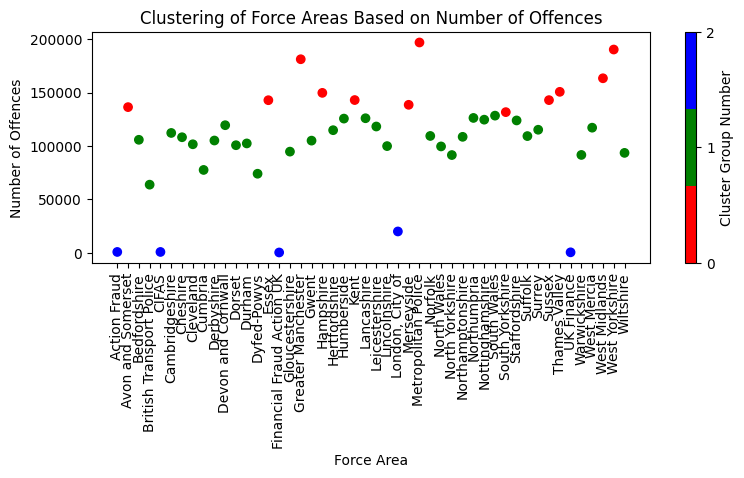

Sum of Squared Errors (SSE): 13193614164.417744


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

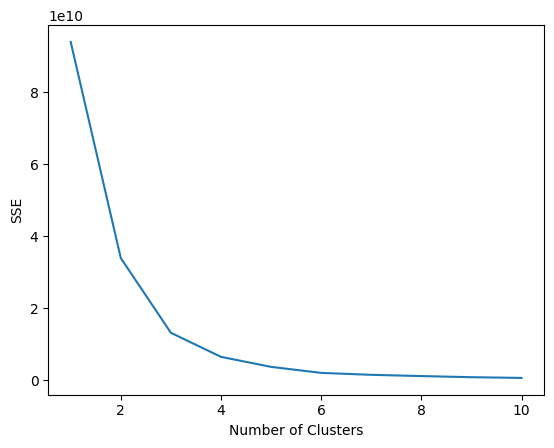

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FuncFormatter

# Load the data
data = pd.read_csv('/content/sample_data/cleancrimedata.csv')

# Group the data by force area and calculate the total number of offences for each area
grouped_data = data.groupby('Force Name')['Number of Offences'].sum().reset_index()

# Define the feature
X = grouped_data[['Number of Offences']]

# Define the model
model = KMeans(n_clusters=3)

# Train the model
model.fit(X)

# Assign the cluster labels to the force areas
grouped_data['cluster'] = model.labels_

# Print the results
print(grouped_data)

# Define the colormap
cmap = ListedColormap(['red', 'green', 'blue'])

# Visualize the results
plt.figure(figsize=(9, 3))
scatter = plt.scatter(range(len(grouped_data)), grouped_data['Number of Offences'], c=grouped_data['cluster'], cmap=cmap)
plt.xlabel('Force Area')
plt.ylabel('Number of Offences')
plt.title('Clustering of Force Areas Based on Number of Offences')
plt.xticks(range(len(grouped_data)), grouped_data['Force Name'], rotation=90)
plt.colorbar(scatter, ticks=np.arange(3), label='Cluster Group Number')
plt.show()

# Calculate SSE for different K values
sse = model.inertia_
print(f'Sum of Squared Errors (SSE): {sse}')
sse = {}
for k in range(1, 11):
    model = KMeans(n_clusters=k)
    model.fit(X)
    sse[k] = model.inertia_

# Plot SSE for different K values
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

Mean Squared Error: 98689594201.0
Predicted number of offences for 2023: 1832874.0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


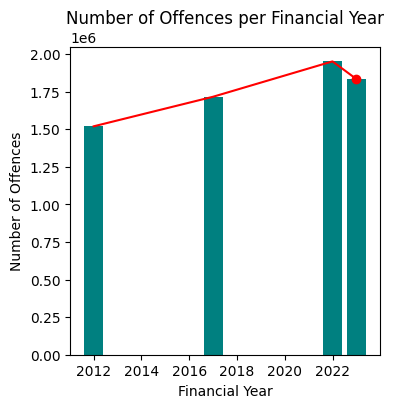

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/sample_data/cleancrimedata.csv'
data = pd.read_csv(file_path)

# Convert 'Financial Year' to a numeric format
data['Financial Year'] = data['Financial Year'].apply(lambda x: int(x.split('/')[0]))

# Aggregate data by financial year
aggregated_data = data.groupby('Financial Year')['Number of Offences'].sum().reset_index()

# Split data
X = aggregated_data[['Financial Year']]
y = aggregated_data['Number of Offences']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = SVR(kernel='linear')
model.fit(X_train, y_train)

# Evaluate the model
predictions = model.predict(X_test)
svr_mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {svr_mse}")

# Predict for the next financial year
next_year = [[2023]]
predicted_offences = model.predict(next_year)
print(f"Predicted number of offences for 2023: {predicted_offences[0]}")

# Create a new DataFrame for plotting
new_data = pd.DataFrame({'Financial Year': next_year[0], 'Number of Offences': [predicted_offences[0]]})
plot_data = pd.concat([aggregated_data, new_data], ignore_index=True)

# Plot the data
plt.figure(figsize=(4, 4))
plt.bar(plot_data['Financial Year'], plot_data['Number of Offences'], color='teal')
plt.plot(plot_data['Financial Year'], plot_data['Number of Offences'], color='red')
plt.scatter(next_year, predicted_offences, color='red')  # Highlight the prediction
plt.xlabel('Financial Year')
plt.ylabel('Number of Offences')
plt.title('Number of Offences per Financial Year')
plt.show()


Mean Squared Error: 38676335569.0
Predicted number of offences for 2023: 1950380.0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


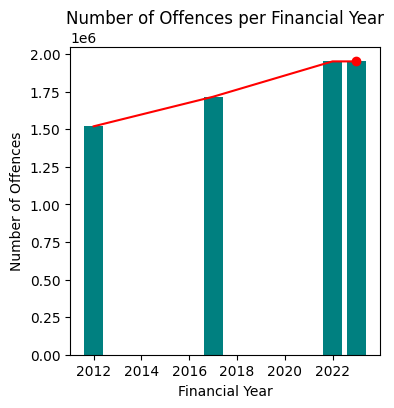

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/sample_data/cleancrimedata.csv'
data = pd.read_csv(file_path)

# Convert 'Financial Year' to a numeric format
data['Financial Year'] = data['Financial Year'].apply(lambda x: int(x.split('/')[0]))

# Aggregate data by financial year
aggregated_data = data.groupby('Financial Year')['Number of Offences'].sum().reset_index()

# Split data
X = aggregated_data[['Financial Year']]
y = aggregated_data['Number of Offences']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
predictions = model.predict(X_test)
dt_mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {dt_mse}")

# Predict for the next financial year
next_year = [[2023]]
predicted_offences = model.predict(next_year)
print(f"Predicted number of offences for 2023: {predicted_offences[0]}")

# Create a new DataFrame for plotting
new_data = pd.DataFrame({'Financial Year': next_year[0], 'Number of Offences': [predicted_offences[0]]})
plot_data = pd.concat([aggregated_data, new_data], ignore_index=True)

# Plot the data
plt.figure(figsize=(4, 4))
plt.bar(plot_data['Financial Year'], plot_data['Number of Offences'], color='teal')
plt.plot(plot_data['Financial Year'], plot_data['Number of Offences'], color='red')
plt.scatter(next_year, predicted_offences, color='red')  # Highlight the prediction
plt.xlabel('Financial Year')
plt.ylabel('Number of Offences')
plt.title('Number of Offences per Financial Year')
plt.show()


Mean Squared Error: 62862428900.91613
Predicted number of offences for 2023: 1885742.075


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


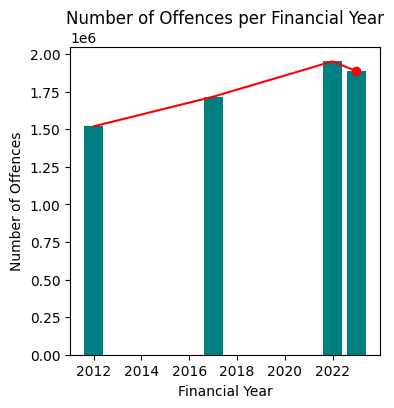

In [ ]:
#bar chart for predicting financial year using randomforest_200

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/sample_data/cleancrimedata.csv'
data = pd.read_csv(file_path)

# Convert 'Financial Year' to a numeric format
data['Financial Year'] = data['Financial Year'].apply(lambda x: int(x.split('/')[0]))

# Aggregate data by financial year
aggregated_data = data.groupby('Financial Year')['Number of Offences'].sum().reset_index()

# Split data
X = aggregated_data[['Financial Year']]
y = aggregated_data['Number of Offences']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
predictions = model.predict(X_test)
rf200_mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {rf200_mse}")

# Predict for the next financial year
next_year = [[2023]]
predicted_offences = model.predict(next_year)
print(f"Predicted number of offences for 2023: {predicted_offences[0]}")

# Create a new DataFrame for plotting
new_data = pd.DataFrame({'Financial Year': next_year[0], 'Number of Offences': [predicted_offences[0]]})
plot_data = pd.concat([aggregated_data, new_data], ignore_index=True)

# Plot the data
plt.figure(figsize=(4, 4))
plt.bar(plot_data['Financial Year'], plot_data['Number of Offences'], color='teal')
plt.plot(plot_data['Financial Year'], plot_data['Number of Offences'], color='red')
plt.scatter(next_year, predicted_offences, color='red')  # Highlight the prediction
plt.xlabel('Financial Year')
plt.ylabel('Number of Offences')
plt.title('Number of Offences per Financial Year')
plt.show()





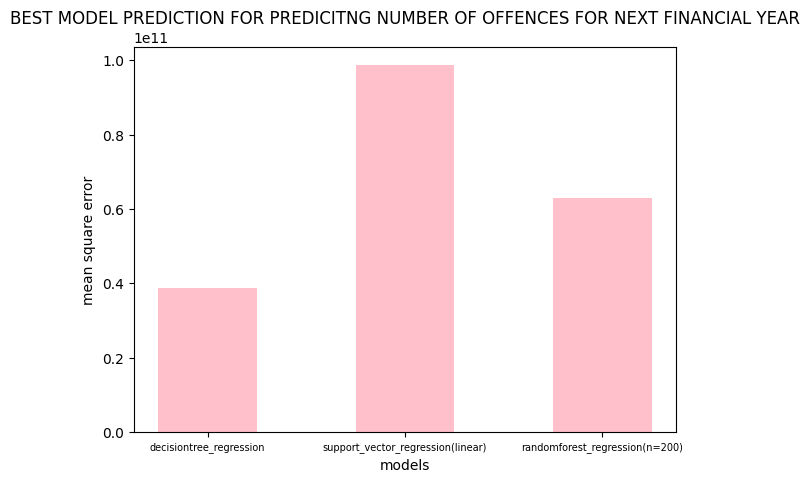

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(7,5))
plt.title('BEST MODEL PREDICTION FOR PREDICITNG NUMBER OF OFFENCES FOR NEXT FINANCIAL YEAR')
plt.xlabel('models')
plt.ylabel('mean square error')
plt.xticks(fontsize=7)

x_axis=np.array(['decisiontree_regression', 'support_vector_regression(linear)', 'randomforest_regression(n=200)'])
y_axis=np.array([dt_mse, svr_mse, rf200_mse ])

plt.bar(x_axis,y_axis,color="pink",width=0.5)
plt.show()

In [ ]:
#bar chart for each offence group using randomforest
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/sample_data/cleancrimedata.csv'
data = pd.read_csv(file_path)

# Convert 'Financial Year' to a numeric format
data['Financial Year'] = data['Financial Year'].apply(lambda x: int(x.split('/')[0]))

# Aggregate data by financial year and offence group
grouped_data = data.groupby(['Financial Year', 'Offence Group'])['Number of Offences'].sum().reset_index()

unique_groups = grouped_data['Offence Group'].unique()

group_predictions = {}

results = []  # List to store the results

for group in unique_groups:
    group_data = grouped_data[grouped_data['Offence Group'] == group]

    X = group_data[['Financial Year']]
    y = group_data['Number of Offences']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    model = RandomForestRegressor(n_estimators=50, random_state=42)
    model.fit(X_train, y_train)

    # Predict for the next financial year
    next_year = X['Financial Year'].max() + 1
    next_year_df = pd.DataFrame([[next_year]], columns=['Financial Year'])
    predicted_offences = model.predict(next_year_df)

    group_predictions[group] = predicted_offences[0]

    # Store the results
    for year, offences in zip(X['Financial Year'], y):
        results.append([group, year, offences])
    results.append([group, next_year, predicted_offences[0]])

    # Make predictions on the test set and calculate MSE
    y_pred = model.predict(X_test)
    forest_mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error for {group}: {forest_mse}')

# Convert the results to a DataFrame
results_df = pd.DataFrame(results, columns=['Offence Group', 'Financial Year', 'Number of Offences'])
print(results_df)

# Plotting
for group in unique_groups:
    group_results = results_df[results_df['Offence Group'] == group]
    plt.figure(figsize=(2, 2))
    plt.bar(group_results['Financial Year'].astype(str), group_results['Number of Offences'])
    plt.bar(next_year_df['Financial Year'].astype(str), group_predictions[group], color='red')
    plt.title(f'Number of Offences for {group} Group')
    plt.xlabel('Financial Year')
    plt.ylabel('Number of Offences')
    plt.legend()
    plt.show()



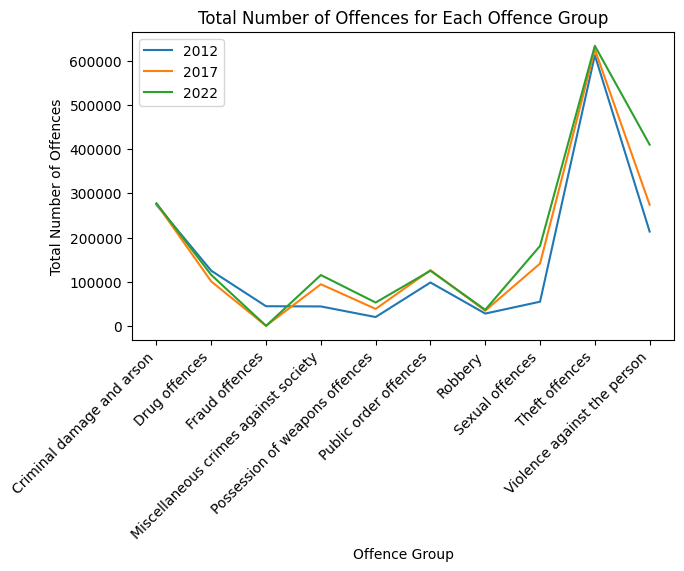

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/sample_data/cleancrimedata.csv'
data = pd.read_csv(file_path)

# Convert 'Financial Year' to a numeric format
data['Financial Year'] = data['Financial Year'].apply(lambda x: int(x.split('/')[0]))

# Specify the years
years = [2012, 2017, 2022]

# Initialize a figure
plt.figure(figsize=(7, 4))

# Loop through each year
for year in years:
    # Filter the data for the specified year
    year_data = data[data['Financial Year'] == year]

    # Aggregate data by offence group
    grouped_data = year_data.groupby('Offence Group')['Number of Offences'].sum().reset_index()

    # Plotting
    plt.plot(grouped_data['Offence Group'], grouped_data['Number of Offences'], label=f'{year}')

# Add labels and title
plt.title('Total Number of Offences for Each Offence Group')
plt.xlabel('Offence Group')
plt.ylabel('Total Number of Offences')
plt.xticks(rotation=45, ha='right')

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/sample_data/cleancrimedata.csv'
data = pd.read_csv(file_path)

# Convert 'Financial Year' to a numeric format
data['Financial Year'] = data['Financial Year'].apply(lambda x: int(x.split('/')[0]))

# Specify the year
year = 2012

# Filter the data for the specified year
year_data = data[data['Financial Year'] == year]

# Aggregate data by offence group
grouped_data = year_data.groupby('Offence Group')['Number of Offences'].sum().reset_index()

# Plotting
plt.figure(figsize=(7, 4))
plt.bar(grouped_data['Offence Group'], grouped_data['Number of Offences'], color='red')
plt.title(f'Total Number of Offences for Each Offence Group in {year}')
plt.xlabel('Offence Group')
plt.ylabel('Total Number of Offences')
plt.xticks(rotation=45, ha='right')
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/sample_data/cleancrimedata.csv'
data = pd.read_csv(file_path)

# Convert 'Financial Year' to a numeric format
data['Financial Year'] = data['Financial Year'].apply(lambda x: int(x.split('/')[0]))

# Specify the year
year = 2017

# Filter the data for the specified year
year_data = data[data['Financial Year'] == year]

# Aggregate data by offence group
grouped_data = year_data.groupby('Offence Group')['Number of Offences'].sum().reset_index()

# Plotting
plt.figure(figsize=(7, 4))
plt.bar(grouped_data['Offence Group'], grouped_data['Number of Offences'], color='green')
plt.title(f'Total Number of Offences for Each Offence Group in {year}')
plt.xlabel('Offence Group')
plt.ylabel('Total Number of Offences')
plt.xticks(rotation=45,ha='right')
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/sample_data/cleancrimedata.csv'
data = pd.read_csv(file_path)

# Convert 'Financial Year' to a numeric format
data['Financial Year'] = data['Financial Year'].apply(lambda x: int(x.split('/')[0]))

# Specify the year
year = 2022

# Filter the data for the specified year
year_data = data[data['Financial Year'] == year]

# Aggregate data by offence group
grouped_data = year_data.groupby('Offence Group')['Number of Offences'].sum().reset_index()

# Plotting
plt.figure(figsize=(7, 4))
plt.bar(grouped_data['Offence Group'], grouped_data['Number of Offences'], color='blue')
plt.title(f'Total Number of Offences for Each Offence Group in {year}')
plt.xlabel('Offence Group')
plt.ylabel('Total Number of Offences')
plt.xticks(rotation=45,ha='right')
plt.show()


Mean Squared Error for Criminal damage and arson: 7034377.017599951
Mean Squared Error for Drug offences: 427872534.6064001
Mean Squared Error for Fraud offences: 1958859081.0
Mean Squared Error for Miscellaneous crimes against society: 3038055656.4736
Mean Squared Error for Possession of weapons offences: 476877279.7503999
Mean Squared Error for Public order offences: 759156787.8400002
Mean Squared Error for Robbery: 47545989.52960001
Mean Squared Error for Sexual offences: 9177218484.839998
Mean Squared Error for Theft offences: 225654475.2400014
Mean Squared Error for Violence against the person: 8675484323.598406


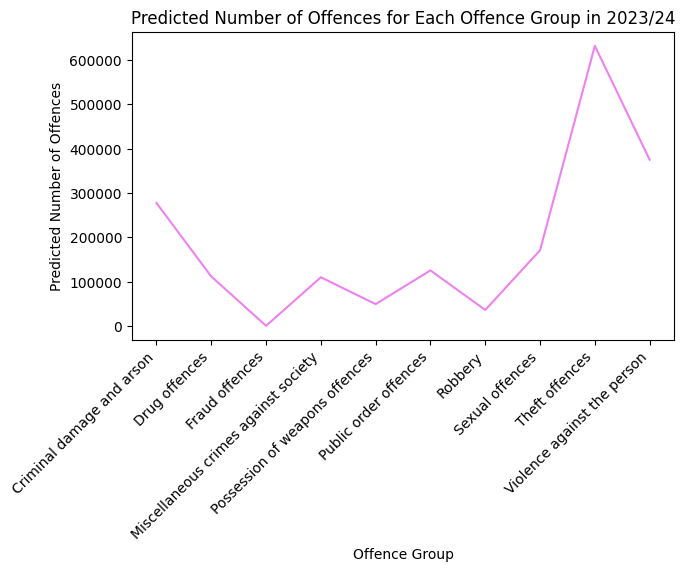

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Group the data by 'Financial Year' and 'Offence Group'
grouped_data = data.groupby(['Financial Year', 'Offence Group'])['Number of Offences'].sum().reset_index()

unique_groups = grouped_data['Offence Group'].unique()

group_predictions = {}
mse_values = {}

for group in unique_groups:
    group_data = grouped_data[grouped_data['Offence Group'] == group]

    X = group_data[['Financial Year']]
    y = group_data['Number of Offences']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

    # Train the model
    model = RandomForestRegressor(n_estimators=50, random_state=42)
    model.fit(X_train, y_train)

    # Predict for the next financial year
    next_year_df = pd.DataFrame([[2023]], columns=['Financial Year'])
    predicted_offences = model.predict(next_year_df)
    group_predictions[group] = predicted_offences[0]

    # Calculate the Mean Squared Error on the test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_values[group] = mse

# Convert predictions to a DataFrame for plotting
predictions_df = pd.DataFrame(group_predictions.items(), columns=['Offence Group', 'Predicted Offences'])

# Print the MSE values
for group, mse in mse_values.items():
    print(f'Mean Squared Error for {group}: {mse}')

# Plotting
plt.figure(figsize=(7, 4))
plt.plot(predictions_df['Offence Group'], predictions_df['Predicted Offences'], color='violet')
plt.title('Predicted Number of Offences for Each Offence Group in 2023/24')
plt.xlabel('Offence Group')
plt.ylabel('Predicted Number of Offences')
plt.xticks(rotation=45,ha='right')
plt.show()


Mean Squared Error for Criminal damage and arson: 6200100.0
Mean Squared Error for Drug offences: 587529121.0
Mean Squared Error for Fraud offences: 1958859081.0
Mean Squared Error for Miscellaneous crimes against society: 2514019600.0
Mean Squared Error for Possession of weapons offences: 337677376.0
Mean Squared Error for Public order offences: 777182884.0
Mean Squared Error for Robbery: 40653376.0
Mean Squared Error for Sexual offences: 7442685441.0
Mean Squared Error for Theft offences: 170589721.0
Mean Squared Error for Violence against the person: 3668603761.0


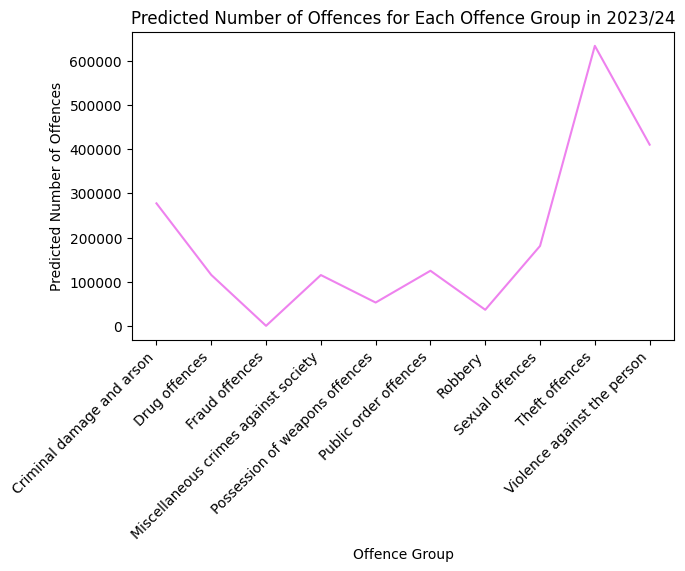

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Group the data by 'Financial Year' and 'Offence Group'
grouped_data = data.groupby(['Financial Year', 'Offence Group'])['Number of Offences'].sum().reset_index()

unique_groups = grouped_data['Offence Group'].unique()

group_predictions = {}
mse_values_dt = {}  # MSE values for Decision Tree

for group in unique_groups:
    group_data = grouped_data[grouped_data['Offence Group'] == group]

    X = group_data[['Financial Year']]
    y = group_data['Number of Offences']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    model = DecisionTreeRegressor(random_state=42)
    model.fit(X_train, y_train)

    # Predict for the next financial year
    next_year_df = pd.DataFrame([[2023]], columns=['Financial Year'])
    predicted_offences = model.predict(next_year_df)
    group_predictions[group] = predicted_offences[0]

    # Calculate the Mean Squared Error on the test set
    y_pred = model.predict(X_test)
    mse_dt = mean_squared_error(y_test, y_pred)  # MSE for Decision Tree
    mse_values_dt[group] = mse_dt

# Convert predictions to a DataFrame for plotting
predictions_df = pd.DataFrame(group_predictions.items(), columns=['Offence Group', 'Predicted Offences'])

# Print the MSE values
for group, mse in mse_values_dt.items():
    print(f'Mean Squared Error for {group}: {mse}')

# Plotting
plt.figure(figsize=(7, 4))
plt.plot(predictions_df['Offence Group'], predictions_df['Predicted Offences'], color='violet')
plt.title('Predicted Number of Offences for Each Offence Group in 2023/24')
plt.xlabel('Offence Group')
plt.ylabel('Predicted Number of Offences')
plt.xticks(rotation=45, ha='right')
plt.show()





Mean Squared Error for Criminal damage and arson: 3290596.0
Mean Squared Error for Drug offences: 1524668209.0
Mean Squared Error for Fraud offences: 1958859081.0
Mean Squared Error for Miscellaneous crimes against society: 864124816.0
Mean Squared Error for Possession of weapons offences: 15626209.0
Mean Squared Error for Public order offences: 854568289.0
Mean Squared Error for Robbery: 17740944.0
Mean Squared Error for Sexual offences: 2169323776.0
Mean Squared Error for Theft offences: 23921881.0
Mean Squared Error for Violence against the person: 5647973409.0


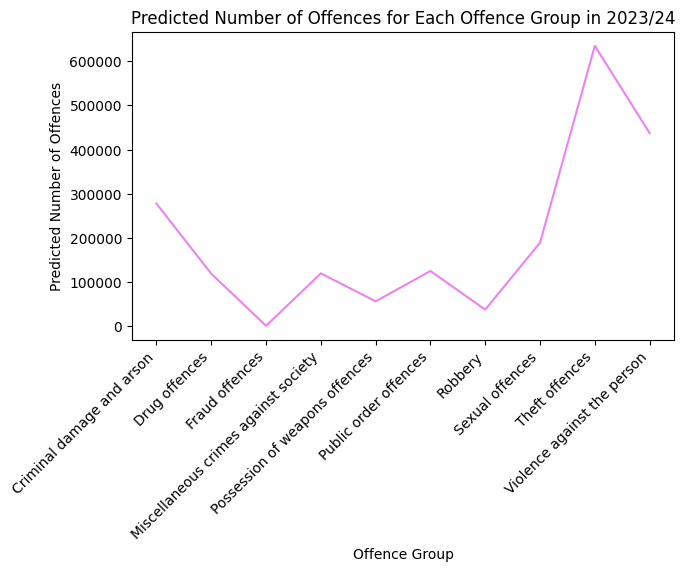

In [ ]:
# offence group using linear regression
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Group the data by 'Financial Year' and 'Offence Group'
grouped_data = data.groupby(['Financial Year', 'Offence Group'])['Number of Offences'].sum().reset_index()

unique_groups = grouped_data['Offence Group'].unique()

group_predictions = {}
mse_values_lr = {}  # MSE values for Linear Regression

for group in unique_groups:
    group_data = grouped_data[grouped_data['Offence Group'] == group]

    X = group_data[['Financial Year']]
    y = group_data['Number of Offences']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict for the next financial year
    next_year_df = pd.DataFrame([[2023]], columns=['Financial Year'])
    predicted_offences = model.predict(next_year_df)
    group_predictions[group] = predicted_offences[0]

    # Calculate the Mean Squared Error on the test set
    y_pred = model.predict(X_test)
    mse_lr = mean_squared_error(y_test, y_pred)  # MSE for Linear Regression
    mse_values_lr[group] = mse_lr

# Convert predictions to a DataFrame for plotting
predictions_df = pd.DataFrame(group_predictions.items(), columns=['Offence Group', 'Predicted Offences'])

# Print the MSE values
for group, mse in mse_values_lr.items():
    print(f'Mean Squared Error for {group}: {mse}')

# Plotting
plt.figure(figsize=(7, 4))
plt.plot(predictions_df['Offence Group'], predictions_df['Predicted Offences'], color='violet')
plt.title('Predicted Number of Offences for Each Offence Group in 2023/24')
plt.xlabel('Offence Group')
plt.ylabel('Predicted Number of Offences')
plt.xticks(rotation=45, ha='right')
plt.show()


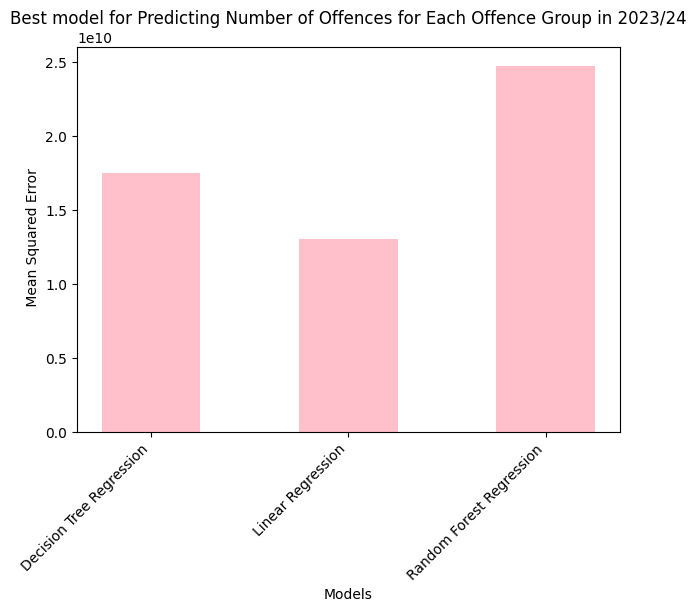

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the average MSE for each model
mse_dt = np.sum(list(mse_values_dt.values()))
mse_lr = np.sum(list(mse_values_lr.values()))
mse_rf = np.sum(list(mse_values.values()))

# Create arrays for the x-axis (models) and y-axis (average MSE)
x_axis = np.array(['Decision Tree Regression', 'Linear Regression', 'Random Forest Regression'])
y_axis = np.array([mse_dt, mse_lr, mse_rf])

# Create the bar plot
plt.figure(figsize=(7, 5))
plt.bar(x_axis, y_axis, color='pink', width=0.5)
plt.title('Best model for Predicting Number of Offences for Each Offence Group in 2023/24')
plt.xlabel('Models')
plt.ylabel(' Mean Squared Error')
plt.xticks(rotation=45, ha='right')
plt.show()


In [ ]:
#mse for each offence group
import matplotlib.pyplot as plt
import numpy as np

# Create arrays for the x-axis (models) and y-axis (MSE)
models = ['Decision Tree Regression', 'Linear Regression', 'Random Forest Regression']
hi= [mse_values_dt, mse_values_lr, mse_values]

# Create a figure and a set of subplots
fig, axs = plt.subplots(len(unique_groups), 1, figsize=(10, len(unique_groups)*5))

for i, group in enumerate(unique_groups):
    # Create arrays for the x-axis (models) and y-axis (MSE for the current group)
    x_axis = np.array(models)
    y_axis = np.array([mse_values_dt[group], mse_values_lr[group], mse_values[group]])

    # Create the bar plot
    axs[i].bar(x_axis, y_axis, color='purple', width=0.5)
    axs[i].set_title(f'Mean Squared Error for {group} in 2023/24')
    axs[i].set_xlabel('Models')
    axs[i].set_ylabel('Mean Squared Error')
    axs[i].set_xticks(x_axis)

plt.tight_layout()
plt.show()



In [ ]:
import csv

file_path = '/content/sample_data/cleancrimedata.csv'
target_force_area = 'Greater Manchester'

total_offenses_for_area = 0

with open(file_path, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row['Force Name'] == target_force_area:
            total_offenses_for_area += float(row['Number of Offences'])

print(f"Total number of offenses in '{target_force_area}': {total_offenses_for_area}")


Total number of offenses in 'Greater Manchester': 181209.92957987761


In [ ]:
import csv

file_path = '/content/sample_data/cleancrimedata.csv'
total_offenses = 0

with open(file_path, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        total_offenses += float(row['Number of Offences'])

print(f"The total number of offenses in the merged data is: {total_offenses}")




The total number of offenses in the merged data is: 5184799.025680831
